In [1]:
# #@title [RUN] Install required python libraries
# import os

# # Install PyTorch Geometric and other libraries
# if 'IS_GRADESCOPE_ENV' not in os.environ:
#     !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#     !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.10.0+cu111.html
#     !pip install -q rdkit-pypi==2021.9.4
#     !pip install -q py3Dmol==1.8.0
#     !pip install -q e3nn
#     !pip install torch-geometric==2.3.1

In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import math
import torch
import torch_geometric
from torch.utils.data import Dataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected

import e3nn
from functools import partial
import itertools

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from experiments.utils.plot_utils import plot_2d, plot_3d
from experiments.utils.train_utils import run_experiment_reg
from models import SchNetModel, DimeNetPPModel, SphereNetModel, EGNNModel, GVPGNNModel, TFNModel, MACEModel

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/pai/envs/grit/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version 1.12.1+cu113
PyG version 2.2.0
e3nn version 0.4.4
Using device: cuda


In [3]:
def create_star_graphs(num=5, fold=3, dim=2, target="max", seed = 0):
    """Generate star graphs with unit-length spokes where angles are randomly assigned."""

    assert dim == 2 or dim == 3, "dimension must be 2 or 3."
    assert target in ["max", "mean"], "regression target must be 'max' or 'mean' of angles"

    torch.manual_seed(seed)
    random.seed(seed)

    dataset = []

    for _ in range(num):
        # atoms representing central and non-central nodes
        atoms = torch.LongTensor([0,] + [0,] * fold)
        # edges read vertically; star graph: 0 -> 1, 0 -> 2 ...
        edge_index = torch.LongTensor( [ [0,] * fold, list(range(1, fold + 1)) ] )
        # origin and first spoke
        x = torch.Tensor([1, 0, 0])
        pos = [torch.Tensor([0, 0, 0]), x]  

        if dim == 2:
            for count in range(1, fold):
                # random angle between 0 and 2*pi
                random_angle = random.uniform(0, 2 * math.pi)
                new_point = torch.Tensor([math.cos(random_angle), math.sin(random_angle), 0])
                pos.append(new_point)

        elif dim == 3:
            for count in range(1, fold):
                theta = random.uniform(0, 2 * math.pi)  # Random angle around z-axis
                phi = random.uniform(0, math.pi)  # Random angle from z-axis (polar angle)
                new_point = torch.Tensor([
                    math.sin(phi) * math.cos(theta),
                    math.sin(phi) * math.sin(theta),
                    math.cos(phi)
                ])
                pos.append(new_point)

        # scale the pos:
        avg_vec = sum(pos)
        alpha = random.uniform(-1, 2)
        pos1 = [p + alpha * avg_vec for p in pos[1:]]
        pos = pos[:1] + pos1
        

        # compute all possible angles
        spoke_positions = pos[1:]
        angles = []
        for combo in itertools.combinations(spoke_positions, 2):
            v1, v2 = combo
            angle = torch.acos(torch.dot(v1, v2) / (torch.norm(v1) * torch.norm(v2)))
            angles.append(angle)
        
        if target == "max":
            y = torch.Tensor([ max(angles) ])
        elif target == "mean":
            y = torch.Tensor([ sum(angles)/len(angles) ])
        
        print(y)

        pos = torch.stack(pos)
        data = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
        data.edge_index = to_undirected(data.edge_index)
        dataset.append(data)

    return dataset

tensor([1.9251])
tensor([0.5289])
tensor([2.6850])
tensor([0.6085])
tensor([1.8881])
tensor([2.9075])
tensor([0.3643])
tensor([3.0462])
tensor([0.5136])
tensor([0.6824])
tensor([1.5470])
tensor([2.8630])
tensor([0.4583])
tensor([2.6703])
tensor([0.8264])
tensor([0.3449])
tensor([1.3288])
tensor([2.6803])
tensor([0.7138])
tensor([0.2341])
tensor([2.5141])
tensor([2.4756])
tensor([0.8619])
tensor([0.4350])
tensor([1.6710])
tensor([0.3869])
tensor([1.8951])
tensor([2.2519])
tensor([0.4350])
tensor([0.4389])
tensor([2.3190])
tensor([1.9188])
tensor([1.4198])
tensor([0.7146])
tensor([1.2531])
tensor([2.5016])
tensor([2.6430])
tensor([0.4763])
tensor([1.0551])
tensor([0.5199])
tensor([1.1490])
tensor([1.3791])
tensor([0.3438])
tensor([0.8466])
tensor([1.1707])
tensor([0.9593])
tensor([0.5956])
tensor([1.4847])
tensor([2.6330])
tensor([1.2292])
tensor([0.2525])
tensor([0.5046])
tensor([0.3933])
tensor([0.6841])
tensor([0.4260])
tensor([0.2769])
tensor([0.5748])
tensor([2.3939])
tensor([0.7519

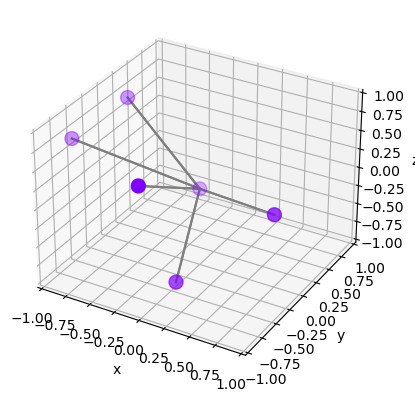

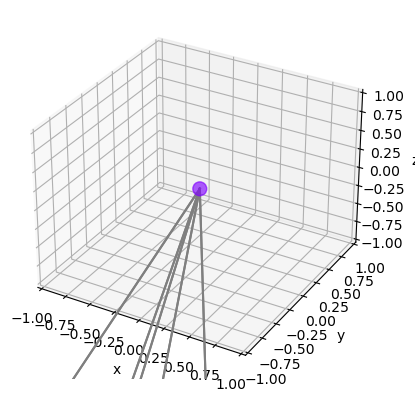

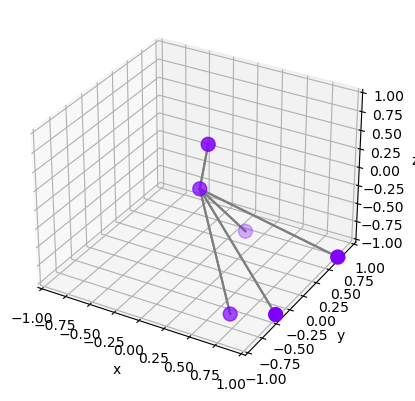

In [4]:
dataset = create_star_graphs(1000, 5, 3)

for data in dataset[:3]:
    plot_3d(data, lim=1)

train_ratio = 0.5
val_ratio = 0.2
test_ratio = 0.3

num_samples = len(dataset)
num_train = int(train_ratio * num_samples)
num_val = int(val_ratio * num_samples)
num_test = num_samples - num_train - num_val

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(0)
)

batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
# Set parameters
model_name = "mace"
correlation = 3
max_ell = 3

model = {
    "schnet": SchNetModel,
    "dimenet": DimeNetPPModel,
    "spherenet": SphereNetModel,
    "egnn": partial(EGNNModel, equivariant_pred=True),
    "gvp": partial(GVPGNNModel, equivariant_pred=True),
    "tfn": partial(TFNModel, max_ell=max_ell, equivariant_pred=True),
    "mace": partial(MACEModel, max_ell=max_ell, correlation=correlation, equivariant_pred=True),
}[model_name](num_layers=2, in_dim=1, out_dim=1)

# regression task
best_val_acc, test_acc, train_time = run_experiment_reg(
    model, 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=600,
    n_times=1,
    device=device,
    verbose=True
)

Running experiment for MACEModel (cuda).


  0%|          | 0/1 [00:00<?, ?it/s]

Running experiment for MACEModel.
Total parameters: 28490817

Start training:
Epoch: 010, LR: 0.00010, Loss: 44.68639, Val MAE: 0.549, Test MAE: 0.527
Epoch: 020, LR: 0.00010, Loss: 33.20871, Val MAE: 0.425, Test MAE: 0.357
Epoch: 030, LR: 0.00010, Loss: 37.80988, Val MAE: 0.482, Test MAE: 0.439
Epoch: 040, LR: 0.00010, Loss: 19.45773, Val MAE: 0.346, Test MAE: 0.302
Epoch: 050, LR: 0.00010, Loss: 22.82073, Val MAE: 0.345, Test MAE: 0.302
Epoch: 060, LR: 0.00010, Loss: 23.84406, Val MAE: 0.341, Test MAE: 0.296
Epoch: 070, LR: 0.00010, Loss: 18.17934, Val MAE: 0.326, Test MAE: 0.245
Epoch: 080, LR: 0.00010, Loss: 17.72441, Val MAE: 0.255, Test MAE: 0.245
Epoch: 090, LR: 0.00010, Loss: 16.42153, Val MAE: 0.310, Test MAE: 0.245
Epoch: 100, LR: 0.00010, Loss: 13.57893, Val MAE: 0.244, Test MAE: 0.209
Epoch: 110, LR: 0.00010, Loss: 14.37612, Val MAE: 0.242, Test MAE: 0.209
Epoch: 120, LR: 0.00010, Loss: 16.73691, Val MAE: 0.286, Test MAE: 0.209
Epoch: 130, LR: 0.00010, Loss: 13.15474, Val M